In [68]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random
from torch.nn import functional as F

In [69]:
os.chdir("/home/atul/diffusion-based-environment-generator/generator")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [70]:
from maze.grid_world_generator import generate_multiple_grid_worlds

generate_multiple_grid_worlds(1, 10)

./data/grid/


Generating Grid Worlds: 100%|██████████| 1/1 [00:00<00:00, 920.61it/s]


In [71]:
class GridWorldDataset(Dataset):
    def __init__(self, directory):
        # print(directory)
        self.files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # print(self.files[idx])
        grid = np.load(self.files[idx])
        return torch.tensor(grid, dtype=torch.int32)

In [72]:
def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    # Below is ChatGPT   
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([0, 0, 1])  # Source → Blue
    img[destination] = np.array([0, 1, 0])  # Destination → Green
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [73]:
dataset = GridWorldDataset("/home/atul/diffusion-based-environment-generator/generator/data/grid")

In [74]:
def display_grid_text(grid):
    """
    Displays the grid world in text format.
    """
    height, width = grid.shape[1], grid.shape[2]
    char_grid = np.full((height, width), '-', dtype=str)
    
    wall = grid[:, :, 0] == 0
    source = grid[:, :, 1] == 1
    destination = grid[:, :, 2] == 1
    
    char_grid = np.full(wall.shape, '-', dtype=str)  # Default to empty space
    char_grid[wall] = '#'  # Walls
    char_grid[source] = 'S'  # Source
    char_grid[destination] = 'E'  # Destination
    
    print("\n".join("".join(row) for row in char_grid))

In [75]:
print(dataset[0].shape)

torch.Size([10, 10, 3])


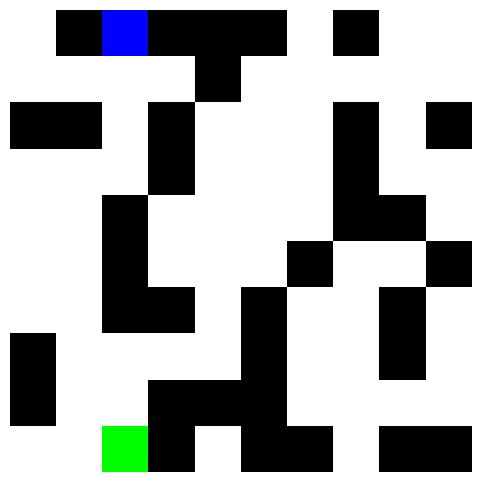

In [76]:
plot_grid_world(dataset[0])

In [77]:
display_grid_text(dataset[0])

-#S###-#--
----#-----
##-#---#-#
---#---#--
--#----##-
--#---#--#
--##-#--#-
#----#--#-
#--###----
--E#-##-##


In [78]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [79]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 10x10x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 5x5x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 3x3x128
            nn.ReLU(),
            nn.Conv2d(128, latent_dim * 2, kernel_size=3, padding=1)  # 3x3x(latent_dim * 2)
        )

        self.latent_dim = latent_dim

    def forward(self, x, noise):
        x = self.encoder(x)  # (B, latent_dim*2, 3, 3)
        
        mean, log_var = torch.chunk(x, 2, dim=1)  # Split into two parts
        log_var = torch.clamp(log_var, -10, 10)  
        var = log_var.exp()
        stdev = var.sqrt()

        z = mean + stdev * noise  # Reparameterization trick
        return mean, log_var, z
    

In [ ]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 128, kernel_size=3, padding=1),  # 3x3x128
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 6x6
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 6x6x64
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 12x12
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 12x12x32
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # 12x12x3 (Extra padding)
        )

    def forward(self, z):
        # Forward pass through decoder
        x = self.decoder(z)  # Shape: (B, 3, 12, 12)

        # Crop to 10x10 (assuming output is 12x12)
        x = x[:, :, :10, :10]

        # Process channels for discrete output
        wall = torch.sigmoid(x[:, 0]) < 0.5 # Channel 1: Sigmoid for walls
        
        # Apply softmax over each pixel (across spatial dimensions) for source and destination
        source = F.softmax(x[:, 1], dim=1)  # Shape: (B, 10, 10)
        destination = F.softmax(x[:, 2], dim=1)  # Shape: (B, 10, 10)

        # Ensure a single position is max for source/destination
        source_idx = source.argmax(dim=1, keepdim=True)  # Shape: (B, 1, 10, 10)
        destination_idx = destination.argmax(dim=1, keepdim=True)  # Shape: (B, 1, 10, 10)

        # Create one-hot encoded source/destination
        source_one_hot = torch.zeros_like(source).scatter_(1, source_idx, 1)
        destination_one_hot = torch.zeros_like(destination).scatter_(1, destination_idx, 1)

        # Stack the channels to return the final output
        return torch.stack([wall, source_one_hot, destination_one_hot], dim=1)

In [ ]:
# import torch
# from torch import nn
# from torch.nn import functional as F
# import math

# class SelfAttention(nn.Module):
#     def __init__(self, n_heads: int, d_embed: int, in_proj_bias=True, out_proj_bias = True):
#         super().__init__()

#         self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
#         self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)

#         self.n_heads = n_heads
#         self.d_head = d_embed // n_heads

#     def forward(self, x: torch.Tensor, casual_mask=False):
#         # x (Batch_size, Seq_Len, Dim)
#         input_shape = x.shape
#         batch_size, seq_len, d_embed = input_shape

#         interim_shape = (batch_size, seq_len, self.n_heads, self.d_head)

#         q, k, v = self.in_proj(x).chunk(3, dim=-1)

#         q = q.view(interim_shape).transpose(1, 2)
#         k = k.view(interim_shape).transpose(1, 2)
#         v = v.view(interim_shape).transpose(1, 2)

#         weight = q @ k.transpose(-1, -2)

#         if casual_mask:
#             mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
#             weight.masked_fill_(mask, -torch.inf)

#         weight /= math.sqrt(self.d_head)

#         weight = F.softmax(weight, dim=-1)

#         output = weight @ v

#         output = output.transpose(1, 2)

#         output = output.reshape(input_shape)
#         output = self.out_proj(output)

#         return output


# class CrossAttention(nn.Module):
#     def __init__(self, n_heads: int, d_embed: int, d_cross: int, in_proj_bias=True, out_proj_bias = True):
#         super().__init__()

#         self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
#         self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
#         self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
#         self.out_proj = nn.Linear(d_embed, d_embed, bias = out_proj_bias)
#         self.n_heads = n_heads
#         self.d_head = d_embed // n_heads

#     def forward(self, x, y):
#         input_shape = x.shape
#         batch_size, seq_len, d_embed = input_shape

#         interim_shape = (batch_size, -1, self.n_heads, self.d_head)

#         q = self.q_proj(x)
#         k = self.k_proj(y)
#         v = self.v_proj(y)

#         q = q.view(interim_shape).transpose(1, 2)
#         k = k.view(interim_shape).transpose(1, 2)
#         v = v.view(interim_shape).transpose(1, 2)

#         weight = q @ k.transpose(-1, -2)
#         weight /= math.sqrt(self.d_head)
#         weight = F.softmax(weight, dim=-1)

#         output = weight @ v
#         output = output.transpose(1, 2).contiguous()
#         output = output.view(input_shape)
#         output = self.out_proj(output)

#         return output

In [ ]:
# class VAE_AttnBlock(nn.Module):
#     def __init__(self, channels: int):
#         super().__init__()
#         self.groupnorm = nn.GroupNorm(32, channels)
#         self.attention = SelfAttention(1, channels)

#     def forward(self, x:torch.Tensor) -> torch.Tensor:
#         residue = x
#         n, c, h, w = x.shape

#         x = x.view(n, c, h * w)
#         x = x.transpose(-1, -2)

#         x = self.attention(x)
#         x = x.transpose(-1, -2)
        
#         x = x.view((n, c, h, w))

#         x += residue
#         return x
        
# class VAE_ResBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.groupnorm_1 = nn.GroupNorm(32, in_channels)
#         self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

#         self.groupnorm_2 = nn.GroupNorm(32, out_channels)
#         self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

#         if in_channels == out_channels:
#             self.residual_layer = nn.Identity()
#         else:
#             self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x: (Batch_size, In_channels, H, W)

#         residue = x

#         x = self.groupnorm_1(x)
#         x = F.silu(x)
#         x = self.conv_1(x)

#         x = self.groupnorm_2(x)
#         x = F.silu(x)
#         x = self.conv_2(x)

#         return x + self.residual_layer(residue)


In [ ]:
# # encoder
# import torch
# from torch import nn
# from torch.nn import functional as F

# class VAE_Encoder(nn.Sequential):

#     def __init__(self):
#         super().__init__(
#             # Initial convolution
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
            
#             # Residual blocks
#             VAE_ResBlock(64, 64),
#             VAE_ResBlock(64, 64),
            
#             # First downsampling (32x32 -> 16x16)
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            
#             # Increased channels
#             VAE_ResBlock(64, 128),
#             VAE_ResBlock(128, 128),
            
#             # Second downsampling (16x16 -> 8x8)
#             nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            
#             # Final processing
#             VAE_ResBlock(128, 256),
#             VAE_ResBlock(256, 256),
#             VAE_AttnBlock(256),
            
#             # Output projection
#             nn.GroupNorm(32, 256),
#             nn.SiLU(),
#             nn.Conv2d(256, 8, kernel_size=3, padding=1),
#             nn.Conv2d(8, 8, kernel_size=1, padding=0)
#         )

#     def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
#         # x: (Batch_size, Channel, H, W)
#         # noise: (Batch_size, out_channels, H/8, W/8)

#         for module in self:
#             if getattr(module, 'stride', None) == (2, 2):
#                 x = F.pad(x, (0, 1, 0, 1))
#             x = module(x)
            
#         # (Batch_size, 8, H, H / 8, W / 8) -> 2 tensors of shape (Batch size, 4, H/8, W/8)
#         mean, log_var = torch.chunk(x, 2, dim=1)
#         log_var = torch.clamp(log_var, -30, 20)
#         var = log_var.exp()
#         stdev = var.sqrt()

#         print(x.shape)
#         print(mean.shape)
#         print(stdev.shape)
#         print(noise.shape)

#         x = mean + stdev * noise

#         x *= 0.18215

#         # return x
#         return mean, log_var, x

In [ ]:
# class VAE_Decoder(nn.Sequential):

#     def __init__(self):
#         super().__init__(
#             # Input projection
#             nn.Conv2d(4, 4, kernel_size=1, padding=0),
#             nn.Conv2d(4, 256, kernel_size=3, padding=1),
            
#             # Residual blocks
#             VAE_ResBlock(256, 256),
#             VAE_AttnBlock(256),
#             VAE_ResBlock(256, 256),
            
#             # First upsampling (8x8 -> 16x16)
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             VAE_ResBlock(128, 128),
#             VAE_ResBlock(128, 128),
            
#             # Second upsampling (16x16 -> 32x32)
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             VAE_ResBlock(64, 64),
#             VAE_ResBlock(64, 64),
            
#             # Output projection
#             nn.GroupNorm(32, 64),
#             nn.SiLU(),
#             nn.Conv2d(64, 3, kernel_size=3, padding=1)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x: (BATCH.SIZE, 4, H / 8, W / 8)

#         print(x.shape)
#         x /= 0.18215

#         for module in self:
#             x = module(x)

#         print("Decoder")
#         print(x.shape)
#         return x


In [112]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 300
LATENT_CHANNELS = 4

In [113]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Training dataset size: {len(dataset)}')

Training dataset size: 1


In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

cuda


In [115]:
def vae_loss(x, x_hat, mean, log_var):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    kl_loss = 0.5 * (mean.pow(2) + log_var.exp() - log_var - 1).sum(dim=(1, 2, 3)).mean()
    
    return recon_loss + kl_loss

In [116]:
from tqdm import tqdm

train_losses = []
for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(tqdm(dataloader, desc="Training", unit="batch")):
        x = x.to(torch.float32).to(device).permute(0, 3, 1, 2)
        batch_size = x.size(0)
        
        noise = torch.randn(batch_size, LATENT_CHANNELS, 2, 2).to(device)
        
        mean, log_var, z = encoder(x, noise)
        x_hat = decoder(z)
        
        loss = vae_loss(x, x_hat, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        
    train_loss = train_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

Training:   0%|          | 0/1 [00:00<?, ?batch/s]/tmp/ipykernel_421795/1042413475.py:2: UserWarning: Using a target size (torch.Size([1, 3, 10, 10])) that is different to the input size (torch.Size([1, 3, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') / x.size(0)
Training:   0%|          | 0/1 [00:00<?, ?batch/s]

torch.Size([1, 8, 2, 2])
torch.Size([1, 4, 2, 2])
torch.Size([1, 4, 2, 2])
torch.Size([1, 4, 2, 2])
Decoder
torch.Size([1, 3, 8, 8])


RuntimeError: The size of tensor a (8) must match the size of tensor b (10) at non-singleton dimension 3

In [99]:
def visualize_grid_world(grid):
    """
    Converts a 3-channel grid world into an RGB image for visualization.
    - First channel: Wall (0 or 1)
    - Second channel: Source (1 if source)
    - Third channel: Destination (1 if destination)
    """
    # Extract channels

    print(grid[:, :, 0])
    wall = grid[:, :, 0] < 0.5
    source = grid[:, :, 1] >= 0.5
    destination = grid[:, :, 2] >= 1
    
    # Create an RGB image with a white background (1, 1, 1)
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    
    # Set walls to black (0, 0, 0)
    img[wall] = np.array([0, 0, 0])
    
    # Set source to blue (0, 0, 1)
    img[source] = np.array([0, 0, 1])
    
    # Set destination to green (0, 1, 0)
    img[destination] = np.array([0, 1, 0])
    
    return img


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 3

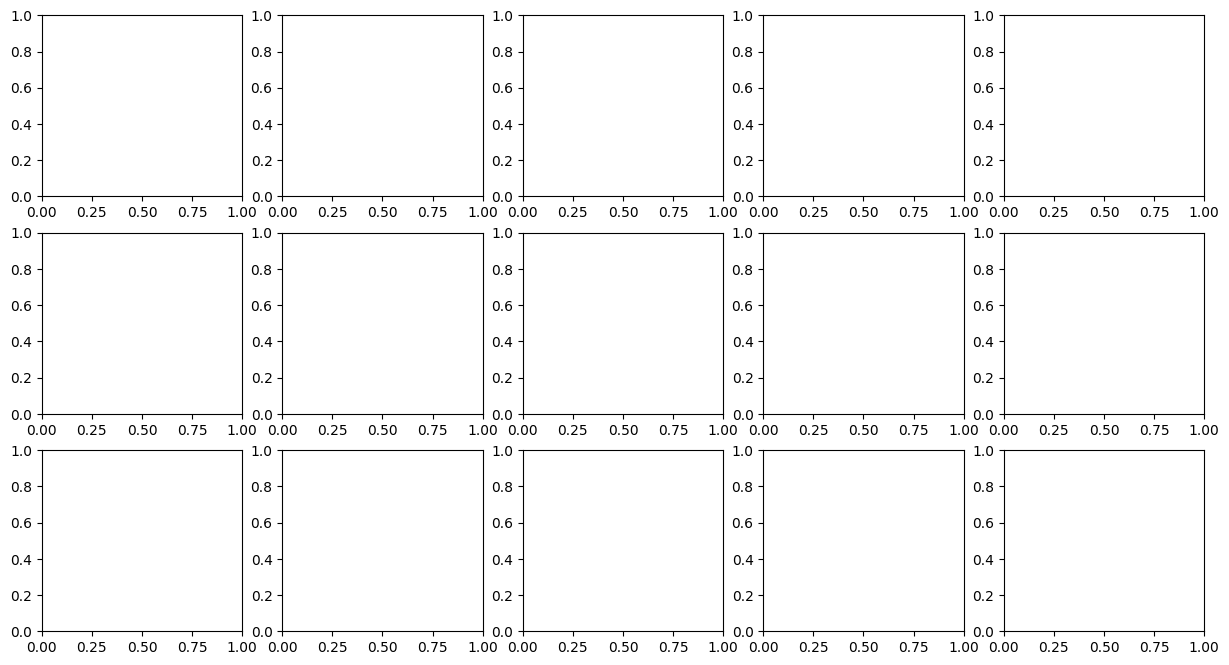

In [100]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))  # Create 3x5 grid of subplots
    
    for i in range(5):
        idx = np.random.randint(len(dataset))
        img = dataset[idx]  # Ignore the path length label for reconstruction
        img = img.unsqueeze(0).to(torch.float32).to(device).permute(0, 3, 1, 2)
        
        # Generate noise for reparameterization trick
        noise = torch.randn(1, LATENT_CHANNELS, 3, 3).to(device)
        
        # Encoder and Decoder
        _, _, z = encoder(img, noise)
        reconstructed = decoder(z).cpu().squeeze(0)
        
        original = img.cpu().squeeze(0)
        
        # Convert the grid world to RGB for visualization
        original_rgb = visualize_grid_world(original.permute(1, 2, 0).numpy())
        reconstructed_rgb = visualize_grid_world(reconstructed.permute(1, 2, 0).numpy())
        
        # Compute the absolute difference between original and reconstructed
        difference = np.abs(original_rgb - reconstructed_rgb)
        
        # Original Image
        axes[0, i].imshow(original_rgb)
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        # Reconstructed Image
        axes[1, i].imshow(reconstructed_rgb)
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
        
        # Difference Image (showing difference in RGB space)
        axes[2, i].imshow(difference)
        axes[2, i].axis('off')
        axes[2, i].set_title('Difference')
    
    plt.tight_layout()
    plt.show()